# Access Computation

This tutorial demonstrates how to compute access.

## Setup

In [3]:
import numpy as np
import pandas as pd

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected = True)

In [4]:
import ostk.mathematics as mathematics
import ostk.physics as physics
import ostk.astrodynamics as astrodynamics

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

to-Python converter for ostk::physics::time::DateTime already registered; second conversion method ignored.

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

to-Python converter for ostk::math::obj::IntervalBase::Type already registered; second conversion method ignored.



In [5]:
RealInterval = Mathematics.Objects.RealInterval

Length = Physics.Units.Length
Angle = Physics.Units.Angle
Scale = Physics.Time.Scale
Instant = Physics.Time.Instant
Duration = Physics.Time.Duration
Interval = Physics.Time.Interval
DateTime = Physics.Time.DateTime
LLA = Physics.Coordinate.Spherical.LLA
AER = Physics.Coordinate.Spherical.AER
Position = Physics.Coordinate.Position
Frame = Physics.Coordinate.Frame
Environment = Physics.Environment
Earth = Physics.Environment.Objects.CelestialBodies.Earth

Trajectory = Astrodynamics.Trajectory
Orbit = Astrodynamics.Trajectory.Orbit
Access = Astrodynamics.Access

---

## Access

An access represents an object-to-object visibility period.

In this example, let's compute accesses between a fixed position on the ground and a satellite in LEO.

## Environment

Let's setup an environment (which describes where planets are, etc...):

In [23]:
environment = Environment.Default() ;

### Origin

Let's define a fixed ground position, using its geographic coordinates:

In [24]:
# Center

# latitude = Angle.Degrees(0.0)
# longitude = Angle.Degrees(0.0)
# altitude = Length.Meters(10.0)

# SvalSat

latitude = Angle.Degrees(78.229772)
longitude = Angle.Degrees(15.407786)
altitude = Length.Meters(10.0)

In [25]:
from_lla = LLA(latitude, longitude, altitude)

In [26]:
from_position = Position.Meters(from_lla.toCartesian(Earth.EquatorialRadius, Earth.Flattening), Frame.ITRF())

And derive a trajectory, fixed at that position:

In [27]:
from_trajectory = Trajectory.Position(from_position)

### Target

Let's consider a satellite in **Low-Earth Orbit**.

In [28]:
earth = environment.accessCelestialObjectWithName("Earth")

We can define its orbit with **Classical Orbital Elements**:

In [29]:
a = Earth.EquatorialRadius + Length.Kilometers(500.0)
e = 0.000
# i = Angle.Degrees(97.5034)
i = Angle.Degrees(97.8893)
raan = Angle.Degrees(100.372)
aop = Angle.Degrees(0.0)
nu = Angle.Degrees(0.0201851)

coe = Orbit.Models.Kepler.COE(a, e, i, raan, aop, nu)

... and by using a **Keplerian** orbital model:

In [30]:
epoch = Instant.DateTime(DateTime(2018, 1, 1, 0, 0, 0), Scale.UTC)

keplerian_model = Orbit.Models.Kepler(coe, epoch, earth, Orbit.Models.Kepler.PerturbationType.J2)

Or with a **Two-Line Element** (TLE) set:

In [31]:
tle = Orbit.Models.SGP4.TLE("ISS (ZARYA)",
                            "1 25544U 98067A   18268.86272795  .00002184  00000-0  40781-4 0  9990",
                            "2 25544  51.6405 237.0010 0003980 205.4375 242.3358 15.53733046134172")

... along with its associated **SGP4** orbital model:

In [32]:
sgp4_model = Orbit.Models.SGP4(tle)

Below, we select which orbital model to use:

In [33]:
orbital_model = keplerian_model
# orbital_model = sgp4_model

We then obtain the satellite orbit (which is a **Trajectory** object):

In [34]:
satellite_orbit = Orbit(orbital_model, earth)

Alternatively, the **Orbit** class can provide some useful shortcuts (for usual orbit types):

In [35]:
epoch = Instant.DateTime(DateTime(2018, 1, 1, 0, 0, 0), Scale.UTC)

satellite_orbit = Orbit.SunSynchronous(epoch, Length.Kilometers(500.0), earth)

### Access

Now that the origin and the target trajectories are well defined, we can compute the **Access**.

Let's first define an **analysis interval**:

In [36]:
start_instant = Instant.DateTime(DateTime.Parse("2018-01-01 00:00:00"), Scale.UTC) ;
end_instant = Instant.DateTime(DateTime.Parse("2018-01-10 00:00:00"), Scale.UTC) ;

interval = Interval.Closed(start_instant, end_instant) ;

Then, using an **Access Generator**, we can compute the accesses within the intervals of interest:

In [51]:
# access_generator = Access.Generator(environment) # Unconstrained access generator

azimuthRange = RealInterval.Closed(0.0, 360.0) # [deg]
elevationRange = RealInterval.Closed(60.0, 90.0) # [deg]
rangeRange = RealInterval.Closed(0.0, 10000e3) # [m]

access_generator = Access.Generator.AerRanges(azimuthRange, elevationRange, rangeRange, environment) # Access generator with Azimuth-Range-Elevation constraints

# access_generator.setStep(Duration.Seconds(5.0)) # To manually set the time step

In [52]:
accesses = access_generator.computeAccesses(interval, from_trajectory, satellite_orbit)

And format the output using a dataframe:

In [53]:
accesses_df = pd.DataFrame([[str(access.getType()), repr(access.getAcquisitionOfSignal()), repr(access.getTimeOfClosestApproach()), repr(access.getLossOfSignal()), float(access.getDuration().inSeconds())] for access in accesses], columns=['Type', 'AOS', 'TCA', 'LOS', 'Duration'])

In [54]:
accesses_df

,Type,AOS,TCA,LOS,Duration
0,Complete,2018-01-01 06:44:27.331.675.885 [UTC],2018-01-01 06:44:27.331.675.885 [UTC],2018-01-01 06:45:44.539.185.760 [UTC],77.207510
1,Complete,2018-01-01 12:59:04.324.438.868 [UTC],2018-01-01 12:59:04.324.438.868 [UTC],2018-01-01 13:00:02.642.226.218 [UTC],58.317787
2,Complete,2018-01-02 06:25:45.070.240.793 [UTC],2018-01-02 06:25:45.070.240.793 [UTC],2018-01-02 06:26:56.233.210.264 [UTC],71.162969
3,Complete,2018-01-02 12:40:34.087.731.241 [UTC],2018-01-02 12:40:34.087.731.241 [UTC],2018-01-02 12:41:08.439.857.659 [UTC],34.352126
4,Complete,2018-01-02 14:14:10.752.656.757 [UTC],2018-01-02 14:14:10.752.656.757 [UTC],2018-01-02 14:15:16.859.097.181 [UTC],66.106440
5,Complete,2018-01-03 06:07:07.881.940.303 [UTC],2018-01-03 06:07:07.881.940.303 [UTC],2018-01-03 06:08:00.881.710.051 [UTC],52.999770
6,Complete,2018-01-03 13:55:20.179.147.123 [UTC],2018-01-03 13:55:20.179.147.123 [UTC],2018-01-03 13:56:36.123.509.108 [UTC],75.944362
7,Complete,2018-01-04 07:22:13.444.360.790 [UTC],2018-01-04 07:22:13.444.360.790 [UTC],2018-01-04 07:23:20.453.224.181 [UTC],67.008863
8,Complete,2018-01-04 13:36:34.964.291.451 [UTC],2018-01-04 13:36:34.964.291.451 [UTC],2018-01-04 13:37:51.933.555.005 [UTC],76.969264
9,Complete,2018-01-05 07:03:25.755.381.881 [UTC],2018-01-05 07:03:25.755.381.881 [UTC],2018-01-05 07:04:41.191.248.893 [UTC],75.435867


In [55]:
len(accesses_df)

22

In [56]:
accesses_df['Duration'].mean() / 60

1.057944064114394

### Output

Let's calculate the geographic coordinate of the satellite, during access:

In [57]:
def compute_lla (state):
    
    lla = LLA.Cartesian(state.getPosition().inFrame(Frame.ITRF(), state.getInstant()).getCoordinates(), Earth.EquatorialRadius, Earth.Flattening)

    return [float(lla.getLatitude().inDegrees()), float(lla.getLongitude().inDegrees()), float(lla.getAltitude().inMeters())]

def compute_aer (instant, from_lla, to_position):
    
    nedFrame = earth.getFrameAt(from_lla, Earth.FrameType.NED)

    fromPosition_NED = from_position.inFrame(nedFrame, instant)
    sunPosition_NED = to_position.inFrame(nedFrame, instant)

    aer = AER.FromPositionToPosition(fromPosition_NED, sunPosition_NED, True)
            
    return [float(aer.getAzimuth().inDegrees()), float(aer.getElevation().inDegrees()), float(aer.getRange().inMeters())]

def compute_time_lla_aer_state (state):
    
    instant = state.getInstant()
    
    lla = compute_lla(state)
    aer = compute_aer(instant, from_lla, state.getPosition().inFrame(Frame.ITRF(), state.getInstant()))

    return [instant, lla[0], lla[1], lla[2], aer[0], aer[1], aer[2]]

def compute_trajectory_geometry (aTrajectory, anInterval):

    return [compute_lla(state) for state in aTrajectory.getStatesAt(anInterval.generateGrid(Duration.Minutes(1.0)))]

def compute_access_geometry (access):

    return [compute_time_lla_aer_state(state) for state in satellite_orbit.getStatesAt(access.getInterval().generateGrid(Duration.Seconds(1.0)))]

In [58]:
satellite_orbit_geometry_df = pd.DataFrame(compute_trajectory_geometry(satellite_orbit, interval), columns=['Latitude', 'Longitude', 'Altitude'])

In [59]:
satellite_orbit_geometry_df.head()

,Latitude,Longitude,Altitude
0,0.099468,-100.369507,500000.063943
1,3.891123,-101.109629,500097.706273
2,7.682070,-101.854134,500379.173802
3,11.471618,-102.607447,500839.456859
4,15.259068,-103.374306,501470.367022


In [60]:
access_geometry_dfs = [pd.DataFrame(compute_access_geometry(access), columns=['Time', 'Latitude', 'Longitude', 'Altitude', 'Azimuth', 'Elevation', 'Range']) for access in accesses] ;

In [61]:
# access_geometry_dfs[0]

In [62]:
def get_max_elevation (df):
    
    return df.loc[df['Elevation'].idxmax()]['Elevation']

In [63]:
[get_max_elevation(access_geometry_df) for access_geometry_df in access_geometry_dfs]

[87.36691733516865,
 69.36264433839804,
 77.22748649889533,
 62.70665041892993,
 73.34524038436665,
 67.24907449989684,
 83.55279336017301,
 74.03903695931183,
 86.44833646330777,
 82.70852905561765,
 77.31280497234364,
 87.60198304030585,
 69.3553825463117,
 63.530874110091325,
 77.46153633168939,
 62.691966186628655,
 73.32110792548328,
 67.46769331551985,
 66.44999183786501,
 83.53411736443216,
 73.83796358660133,
 86.45885372280495]

And plot the geometries onto a map:

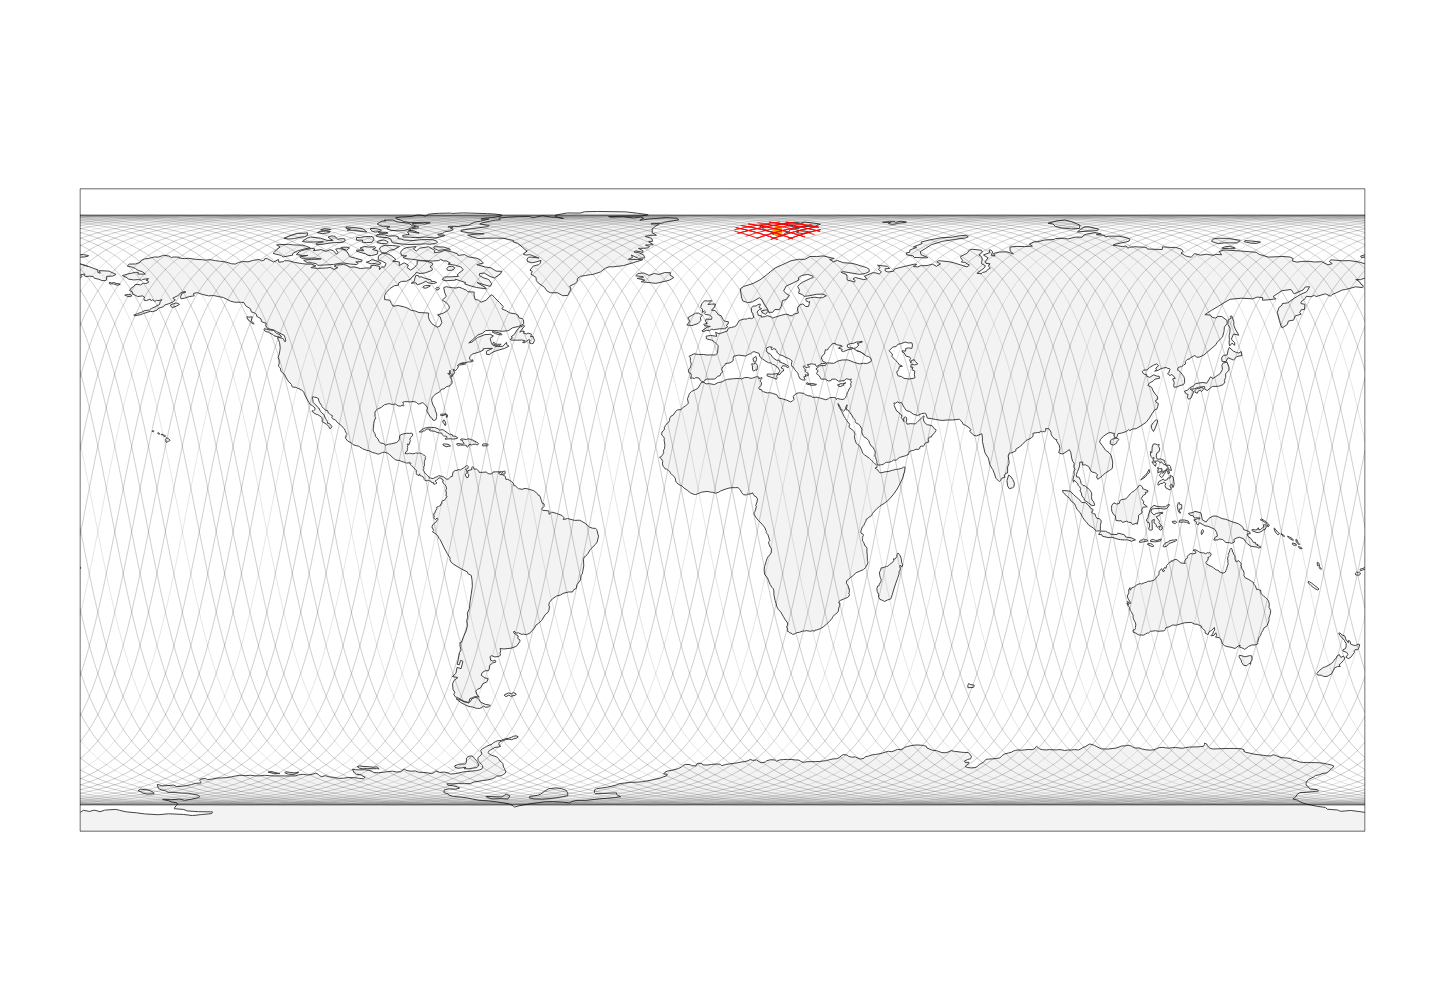

In [64]:
data = []

# Target geometry

data.append(
    dict(
        type = 'scattergeo',
        lon = [float(longitude.inDegrees())],
        lat = [float(latitude.inDegrees())],
        mode = 'markers',
        marker = dict(
            size = 10,
            color = 'orange'
        )
    )
)

# Orbit geometry

data.append(
    dict(
        type = 'scattergeo',
        lon = satellite_orbit_geometry_df['Longitude'],
        lat = satellite_orbit_geometry_df['Latitude'],
        mode = 'lines',
        line = dict(
            width = 1,
            color = 'rgba(0, 0, 0, 0.1)',
        )
    )
)

# Access geometry

for access_geometry_df in access_geometry_dfs:
    
    data.append(
        dict(
            type = 'scattergeo',
            lon = access_geometry_df['Longitude'],
            lat = access_geometry_df['Latitude'],
            mode = 'lines',
            line = dict(
                width = 1,
                color = 'red',
            )
        )
    )
    
layout = dict(
        title = None,
        showlegend = False,
        height = 1000,
        geo = dict(
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )
    
fig = dict(data = data, layout = layout)
iplot(fig)